<a href="https://colab.research.google.com/github/shepai/BIORTC_Nigeria/blob/main/Workshops/rnn_gng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training Recurrent Neural Networks
==================================



[slides](https://docs.google.com/presentation/d/18BdxIs2NM171ckuOeZWY-WHR9XSoqTwiCp-iCntqsjg/edit?usp=sharing)

## Settings



In [1]:
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

golden_ratio = (5**.5 - 1) / 2
width = 5
height = width * golden_ratio

plt.rc("axes.spines", top=False, right=False)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams["figure.autolayout"] = True
plt.rcParams['lines.markersize'] = 5
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

## Imports



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [3]:
torch.manual_seed(2)
np.random.seed(2)

## 🧠 Dynamical RNNs



Let:

-   $ x_t $: feedforward input at time step $ t $
-   $ r_t $: rate at time $ t $
-   $ y_t $: output at time $ t $

$$
r_t = (1 - \frac{\delta t}{\tau}) r_{t-1} + \frac{\Delta t}{\tau} \mathcal{F}(W_{ih} x_t + b_{ih} + W_{hh} r_{t-1})
$$

$$
y_t = \mathcal{S}(W_{ho} r_t + b_o)
$$



In [4]:
class BioRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dt=0.1, tau=1.0, sigma=0.1):
        super().__init__()
        # input layer
        self.wi = nn.Linear(input_size, hidden_size)
        # recurrent layer
        self.wrec = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        nn.init.xavier_uniform_(self.wrec)
        # output layer
        self.wo = nn.Linear(hidden_size, output_size)
        # non linearity
        self.nonlinearity = torch.tanh
        # time constant
        self.DT_TAU = dt / tau
        # variance of the noise
        self.sigma = sigma


    def update_dynamics(self, ff_inputs, rates, noise):
        # updating the recurrent inputs and rates
        rec_inputs = rates @ self.wrec.T # / rates.shape[-1]
        nonlinear = self.nonlinearity(self.wi(ff_inputs) + rec_inputs)
        # here we use the Euler-Murayama scheme
        rates = (1-self.DT_TAU) * rates + self.DT_TAU * nonlinear + torch.sqrt(torch.tensor(self.DT_TAU))* noise

        return rates, rec_inputs


    def forward(self, ff_inputs):
        # This is the main function of the class
        # ff_input is (n_trials, seq_len, input_size)
        # we create rates and rec_inputs are (n_trials, hidden_size)
        noise = self.sigma * torch.randn(ff_inputs.shape[0], self.wrec.shape[0])
        rec_inputs = torch.randn(ff_inputs.shape[0], self.wrec.shape[0])
        rates = self.nonlinearity(self.wi(ff_inputs[:, -1]) + rec_inputs)

        readout_list = []
        # for each step in the sequence we update the dynamics
        for step in range(ff_inputs.shape[1]):
            rates, rec_inputs = self.update_dynamics(ff_inputs[:, step], rates, noise)
            # compute the readout
            readout = self.wo(rates)
            # and save the readout
            readout_list.append(readout)

        readout_list = torch.stack(readout_list, dim=1)

        return readout_list

---



## Initializing the model



We first define the network parameters (input_size, hidden_size, output_size) and we initialize the model

In [5]:
input_size = 32
hidden_size = 128
output_size = 1

model = BioRNNModel(input_size, hidden_size, output_size)

## Generating a Go/NoGo task



Let's create the task, first we define the task parameters (stimulus times, sequence length, response, ...)

In [6]:
DT = 0.1
stim_onset = int(1 / DT)
stim_offset = int(2 / DT)
response_onset = int(3 / DT)

seq_len = int(4 / DT)
x_time = np.linspace(0, 4, seq_len)

Now we need to create inputs that will mimic the go and no go trials

In [7]:
def generate_gng_trials(n_trials, seq_len, input_size, noise=0.2):
    """Generates one trial of Delayed Go/No-Go."""
    inputs = noise * torch.randn((n_trials, seq_len, input_size))
    targets = torch.zeros((n_trials, seq_len))
    mask = torch.zeros((1, seq_len))

    # Decide if it's a Go (1) or No-Go (0) trial
    is_go = torch.rand(n_trials) > 0.5
    # Apply input stimulus early in sequence
    inputs[is_go, stim_onset:stim_offset] += 1.0
    inputs[~is_go, stim_onset:stim_offset] -= 1.0
    # Output only during Go time
    targets[is_go, response_onset:] += 1.0
    targets[~is_go, response_onset:] -= 1.0

    mask[0, response_onset:] += 1.0

    return inputs, targets, mask

Let's generate some trials

In [8]:
n_trials = 512
inputs, targets, mask = generate_gng_trials(n_trials, seq_len, input_size)
print(inputs.shape, targets.shape, mask.shape)

torch.Size([512, 40, 32]) torch.Size([512, 40]) torch.Size([1, 40])


We can check that we created almost the same proportion of go and nogo trials

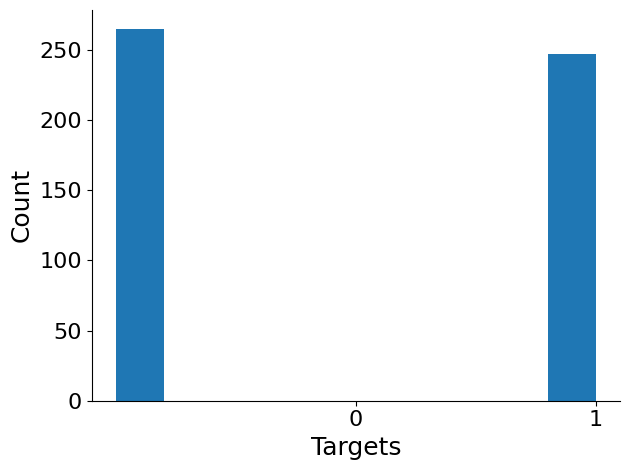

In [9]:
plt.hist(targets[..., -1].reshape(-1), bins='auto')
plt.xlabel('Targets')
plt.ylabel('Count')
plt.xticks([0, 1])
plt.show()

Let's split the trials based on the target

In [10]:
idx_nogo = torch.argwhere(targets[:, -1] == -1).reshape(-1)[:32]
idx_go = torch.argwhere(targets[:, -1] == 1).reshape(-1)[:32]
print(idx_go.shape, idx_nogo.shape)

torch.Size([32]) torch.Size([32])


and plot the respective inputs and targets

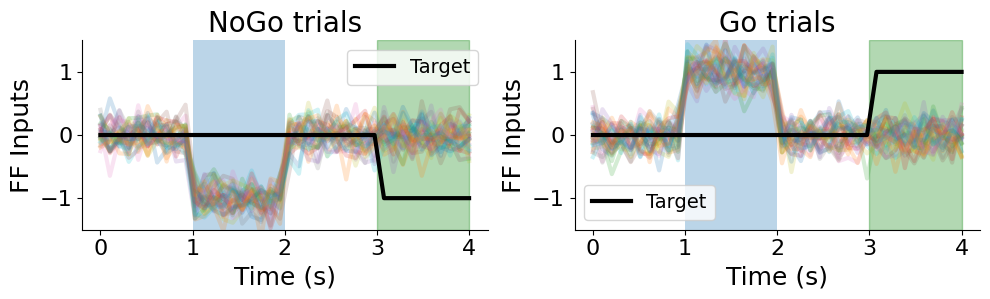

In [11]:
fig , ax = plt.subplots(1, 2, figsize=(2*width, height))

ax[0].plot(x_time, inputs[idx_nogo, :, 0].mT.cpu().numpy(), alpha=.2)
ax[0].plot(x_time, targets[idx_nogo[0]].cpu().numpy(), 'k', label='Target')
ax[0].set_title('NoGo trials')

ax[1].plot(x_time, inputs[idx_go, :, 0].mT.cpu().numpy(), alpha=.2)
ax[1].plot(x_time, targets[idx_go[0]].cpu().numpy(), 'k', label='Target')
ax[1].set_title('Go trials')

for i in range(2):
    ax[i].axvspan(stim_onset * DT, stim_offset * DT, alpha=0.3)
    ax[i].axvspan(response_onset * DT, seq_len * DT, alpha=0.3, color='g')
    ax[i].set_ylim([-1.5, 1.5])
    ax[i].set_xlabel('Time (s)')
    ax[i].set_ylabel('FF Inputs')
    ax[i].legend(fontsize=14)
plt.show()

Now we can test the naive network on the task

In [12]:
predictions = model(inputs).squeeze((0, -1)).detach().cpu()
print('inputs', inputs.shape, 'predictions', predictions.shape)

inputs torch.Size([512, 40, 32]) predictions torch.Size([512, 40])


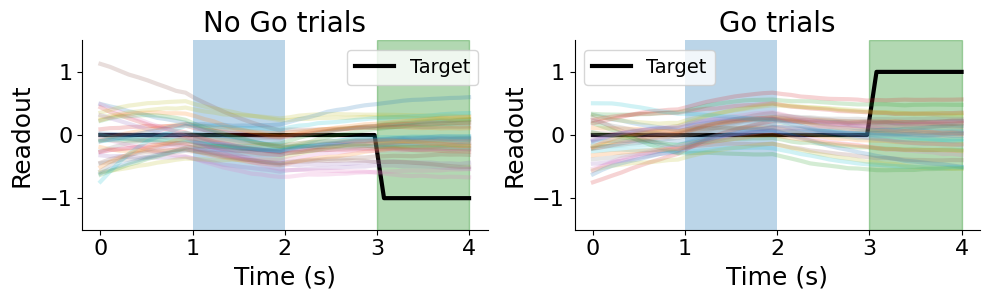

In [13]:
fig , ax = plt.subplots(1, 2, figsize=(2*width, height))

ax[0].plot(x_time, targets[idx_nogo][0], 'k', label='Target')
ax[0].plot(x_time, predictions[idx_nogo].T, alpha=.2)
ax[0].set_title('No Go trials')

ax[1].plot(x_time, targets[idx_go][0], 'k', label='Target')
ax[1].plot(x_time, predictions[idx_go].T, alpha=.2)
ax[1].set_title('Go trials')

for i in range(2):
    ax[i].axvspan(stim_onset * DT, stim_offset * DT, alpha=0.3)
    ax[i].axvspan(response_onset * DT, seq_len * DT, alpha=0.3, color='g')
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Readout")
    ax[i].set_ylim([-1.5, 1.5])
    ax[i].legend(fontsize=14)

plt.show()

As you can see the network does not do the task

## Training the model



Let's define the parameters of the optimization

In [14]:
learning_rate = 0.05
epochs = 50
batch_size = 32

and define our optimization loop

In [15]:
def optimization(model, X, Y, criterion, optimizer, mask=1, epochs=30, batch_size=32, bl=stim_offset, verbose=1):

    loss_list = []
    for epoch in range(epochs):
        permutation = torch.randperm(X.size(0))

        total_loss = 0
        for i in range(0, X.size(0), batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X[indices], Y[indices]

            output = model(batch_x).squeeze(-1)

            # compute error during response window
            loss = criterion(output, batch_y) * mask
            loss = torch.mean(loss)

            # impose zero readout before stimulus offset
            loss_bl = criterion(output[:, :bl], batch_y[:, :bl]*0) * (1-mask[:, :bl])
            loss += torch.mean(loss_bl)

            # propagate the loss backwards
            loss.backward()
            # update the weights
            optimizer.step()
            # reset the weights for the next pass
            optimizer.zero_grad()

        loss_list.append(total_loss)

        if (verbose) and (((epoch+1) % 5==0) or (epoch==epochs-1) or (epoch==0)):
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {loss:.4f}')

    return loss_list



Now we choose a loss, an optimizer and run the optimization

In [16]:
criterion = nn.MSELoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss = optimization(model, inputs, targets, criterion, optimizer, mask, epochs)

Epoch 1/50, Training Loss: 0.1158
Epoch 5/50, Training Loss: 0.0293
Epoch 10/50, Training Loss: 0.0063
Epoch 15/50, Training Loss: 0.0057
Epoch 20/50, Training Loss: 0.0050
Epoch 25/50, Training Loss: 0.0075
Epoch 30/50, Training Loss: 0.0075
Epoch 35/50, Training Loss: 0.0029
Epoch 40/50, Training Loss: 0.0191
Epoch 45/50, Training Loss: 0.0029
Epoch 50/50, Training Loss: 0.0045


Let's plot the loss

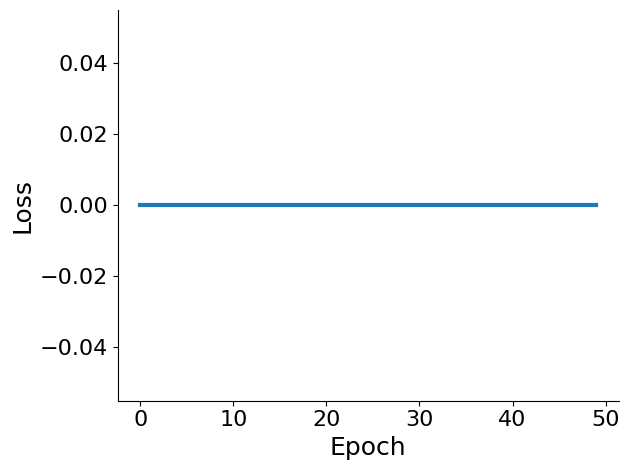

In [17]:
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

The loss converges quickly to a small value

## Testing the model



Now we can test the trained model on the go nogo task

In [18]:
inputs, targets, mask = generate_gng_trials(n_trials, seq_len, input_size)
predictions = model(inputs).squeeze((0, -1)).detach().cpu()
print('inputs', inputs.shape, 'predictions', predictions.shape)

inputs torch.Size([512, 40, 32]) predictions torch.Size([512, 40])


let's split the trials

In [19]:
idx_nogo = torch.argwhere(targets[:, -1] == -1).reshape(-1)[:32]
idx_go = torch.argwhere(targets[:, -1] == 1).reshape(-1)[:32]

and plot the network output

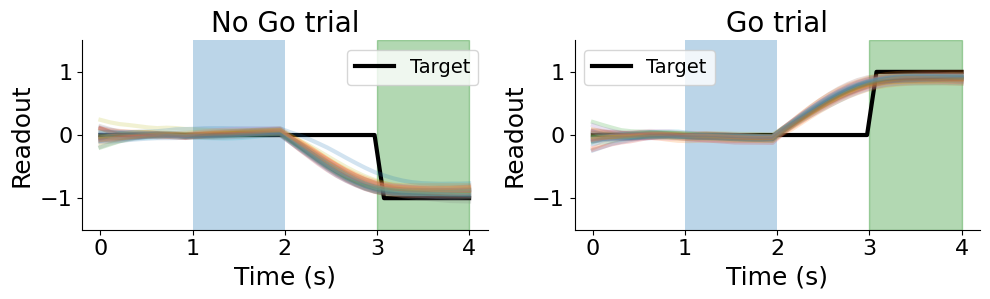

In [20]:
fig , ax = plt.subplots(1, 2, figsize=(2*width, height))

ax[0].plot(x_time, targets[idx_nogo][0], 'k', label='Target')
ax[0].plot(x_time, predictions[idx_nogo].T, alpha=.2)
ax[0].set_title('No Go trial')

ax[1].plot(x_time, targets[idx_go][0], 'k', label='Target')
ax[1].plot(x_time, predictions[idx_go].T, alpha=.2)
ax[1].set_title('Go trial')

for i in range(2):
    ax[i].axvspan(stim_onset * DT, stim_offset * DT, alpha=0.3)
    ax[i].axvspan(response_onset * DT, seq_len * DT, alpha=0.3, color='g')
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Readout")
    ax[i].set_ylim([-1.5, 1.5])
    ax[i].legend(fontsize=14)

plt.show()

The network performs the task perfectly!

